In [1]:
using Distributions, Plots, Plots.PlotMeasures, Printf, Random, RxInfer, StableRNGs

# Generative process

We have a generative process that, for any hidden state $x \in \mathbb{R}$, generates a random outcome according to

$$y \sim \mathcal{N}(g_{\mathcal{E}}(x, \mathbf{\beta}), \sigma_y^2)$$

where:

 - $\pmb{\beta} = [\beta_0, \beta_1]^\top$
 - $g_{\mathcal{E}}(x, \pmb{\beta}) = \beta_0 + \beta_1 x$ is the generating function for the generative process
 - for any $\mu$ and $\sigma^2$, $\mathcal{N}(\mu, \sigma^2)$ is the univariate Gaussian with mean $\mu$ and variance $\sigma^2$
 - $\sigma_y^2$ is a particular, fixed variance for the process

An equivalent formulation is:

$$y = g_{\mathcal{E}}(x, \pmb{\beta}) + \omega_y$$

where $\omega_y \sim \mathcal{N}(0, \sigma^2)$ is a zero-mean Gaussian noise term.

As in section 2.1 of the Fundamentals of Active Inference draft, we assume that there is a single, true, fixed latent state $x^{\ast}$

# Generative model

The above is written from the omniscient view of someone with access to the true state of the world. As mere agents, the true state is hidden from us. We seek to model and infer this state. Namely, we can establish a prior model $p(x)$ of the true state, an observation model $p(y|x)$ of observations conditional on state, and use the product rule from probability to construct the joint distribution over states and observations:

$$p(x, y) = p(y | x) p(x)$$

Pretending we didn't just formally define the generative process above, let's assume the agent uses prior knowledge somehow and "guesses" that a linear Gaussian observation model would work well:

$$p(y | x) = \mathcal{N}(y | g_{\mathcal{M}}(x, \mathbf{\gamma}), \eta_y^2)$$

where:

 - $\pmb{\gamma} = [\gamma_0, \gamma_1]^\top$
 - $g_{\mathcal{M}}(x, \pmb{\gamma}) = \gamma_0 + \gamma_1 x$ is our model of the process' generating function
 - $\eta_y^2$ is a fixed variance of the observation model

For the prior, we assume a Gaussian:

$$p(x) = \mathcal{N}(x | \mu_x, \sigma_x^2)$$

This modeling assumption reflects a belief that the hidden state is a continuous variable that can take on any real value $x \in (- \infty, + \infty)$. Different beliefs might lead us to different choice of prior (e.g. a log-normal prior for $x \in (0, \infty)$, or a categorical prior for a discrete $x$)

In [2]:
function make_linear_gaussian(a, b, v, x, rng)
    num_samples = length(x)
    y = a .+ b * x .+ randn(rng, num_samples) * sqrt(v)
    return x, y
end

function generative_process(x, β, var_y, rng)
    xs = [x]
    return make_linear_gaussian(β[1], β[2], var_y, xs, rng)
end


function generative_model(ys, mu_x::Float64, stddev_x::Float64, γ::Vector{Float64}, stddev_y::Float64, rng)
    g_M = x -> γ[1] + γ[2] * x

    prior = Normal(mu_x, stddev_x)
    likelihood = x -> Normal(g_M(x), stddev_y)
    
    xs = range(0, 6, length = 1000)

    plot!(xs, (x) -> pdf.(prior, x), fillalpha=0.3, fillrange=0, label="p(x)", c=1)
    plot!(xs, (x) -> pdf.(likelihood(x), ys[1]), fillalpha=0.3, fillrange=0, label="p(y|x)", c=2)

    # use eval() to workaround limitation of the @model macro
    model_expr = :(@model function gen_model(n::Int64, mu_x::Float64, stddev_x::Float64, γ, stddev_y)
       y = datavar(Float64, n)
       x ~ NormalMeanVariance(mu_x, stddev_x)
   
       for i in 1:n
           y[i] ~ NormalMeanVariance(γ[1] + γ[2] * x, stddev_y)
       end
    end)

    eval(model_expr)

    result = infer(
        model = gen_model(length(ys), mu_x, stddev_x, γ, stddev_y), 
        data  = (y = ys, ),
        free_energy  = true
    )

    posterior = result.posteriors[:x]

    plot!(xs, (x) -> pdf(posterior, x), fillalpha=0.3, fillrange = 0, label="p(x|y)", c=3)
end;

In [3]:
seed = 299792458

rng = StableRNG(seed)

StableRNGs.LehmerRNG(state=0x00000000000000000000000023bcf095)

In [4]:
# example 2b from FOAI
x_hidden = 2
β = [3, 2]
var_y = 1
x_data, y_data = generative_process(x_hidden, β, var_y, rng)

([2], [7.635260638352808])

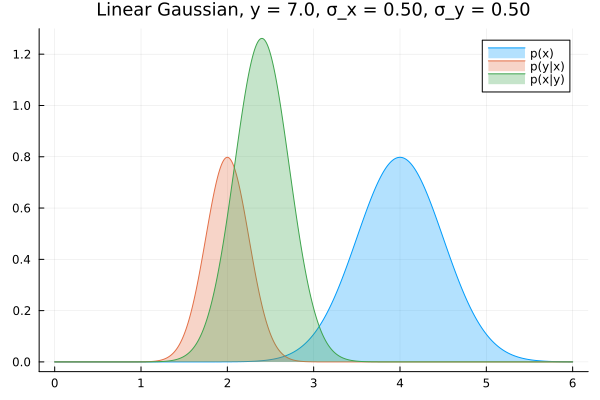

In [6]:
# actually, don't use what we previously generated, use hardcoded 7 as example
y_data = [7.0]

make_plot_title(y, stddev_x, stddev_y) = "Linear Gaussian, y = $(@sprintf("%.1f", y)), σ_x = $(@sprintf("%.2f", stddev_x)), σ_y = $(@sprintf("%.2f", stddev_y))"

# assume we've already learned the correct γ parameters, somehow
mu_x = 4.0
stddev_x = sqrt(0.25)
γ = [3.0, 2.0]
stddev_y = sqrt(0.25)


plot(title=make_plot_title(y_data[1], stddev_x, stddev_y), titlefontsize=12)
generative_model(y_data, mu_x, stddev_x, γ, stddev_y, rng)
#vline!(x_data, label="x", c=4)

# Precision

We can alternatively parameterize any Gaussian by defining the **precision** as the inverse variance:

$$\lambda := \frac{1}{\sigma^2}$$

High variance = low precision, and vice versa.

Above, we considered the case of equal prior and likelihood precision/variance. We can consider two alternative cases:

 - high prior precision and low likelihood precision, or $\sigma_x^2 < \sigma_y^2$
 - and low prior precision and high likelihood precision, or $\sigma_x^2 > \sigma_y^2$

## High prior precision, low likelihood precision

The model relies primarily on the prior.

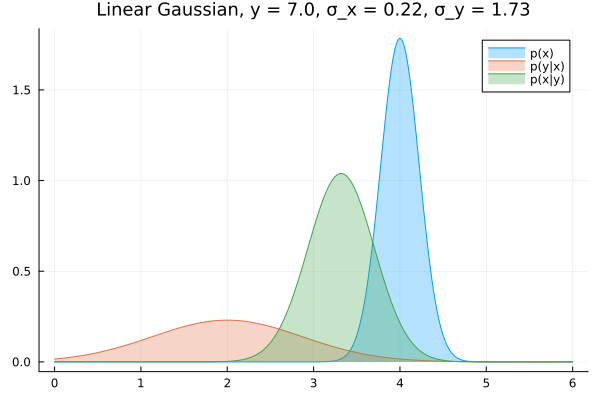

In [7]:
plot()
# high prior precision, low likelihood precision

mu_x = 4.0
stddev_x = sqrt(0.05)
γ = [3.0, 2.0]
stddev_y = sqrt(3.0)

y_data = [7.0]
plot(title=make_plot_title(y_data[1], stddev_x, stddev_y), titlefontsize=12)
generative_model(y_data, mu_x, stddev_x, γ, stddev_y, rng)

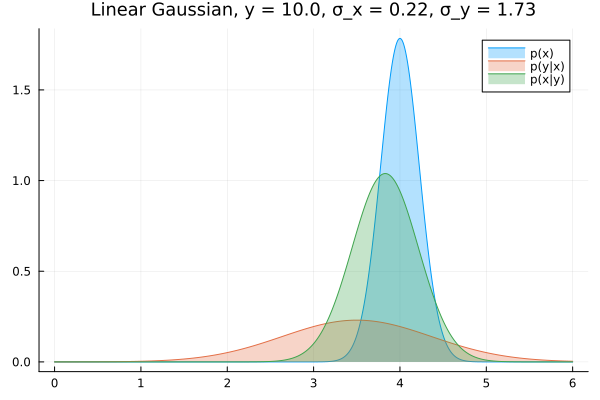

In [8]:
plot()

y_data = [10.0]
plot(title=make_plot_title(y_data[1], stddev_x, stddev_y), titlefontsize=12)
generative_model(y_data, mu_x, stddev_x, γ, stddev_y, rng)

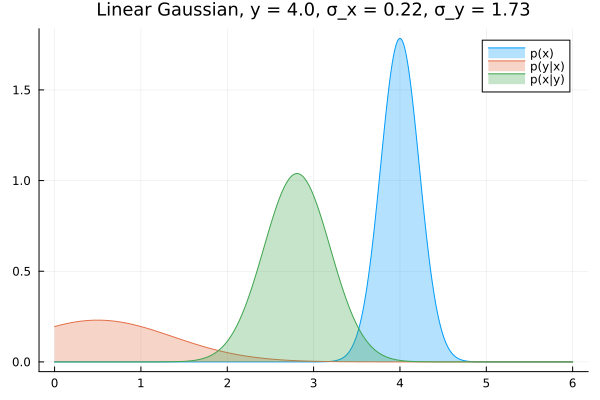

In [9]:
plot()

y_data = [4.0]
plot(title=make_plot_title(y_data[1], stddev_x, stddev_y), titlefontsize=12)
generative_model(y_data, mu_x, stddev_x, γ, stddev_y, rng)

## Low prior precision, high likelihood precision

The model relies primarily on the observation.

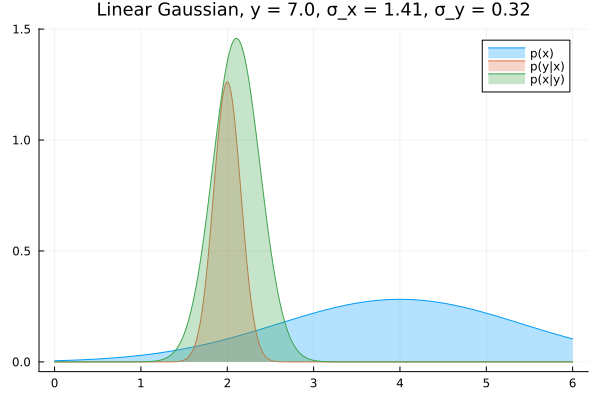

In [11]:
plot()

mu_x = 4.0
stddev_x = sqrt(2)
γ = [3.0, 2.0]
stddev_y = sqrt(0.1)

y_data = [7.0]
plot(title=make_plot_title(y_data[1], stddev_x, stddev_y), titlefontsize=12)
generative_model(y_data, mu_x, stddev_x, γ, stddev_y, rng)

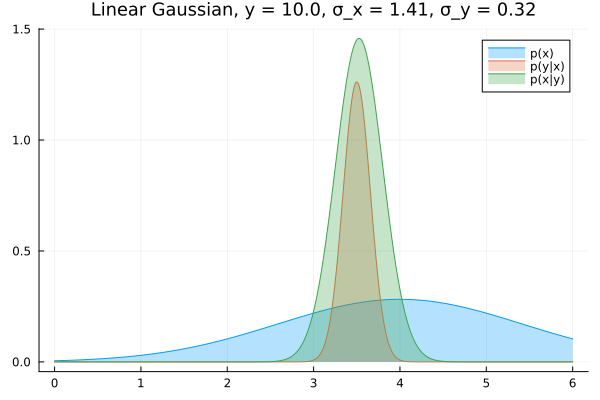

In [12]:
plot()
y_data = [10.0]
plot(title=make_plot_title(y_data[1], stddev_x, stddev_y), titlefontsize=12)
generative_model(y_data, mu_x, stddev_x, γ, stddev_y, rng)

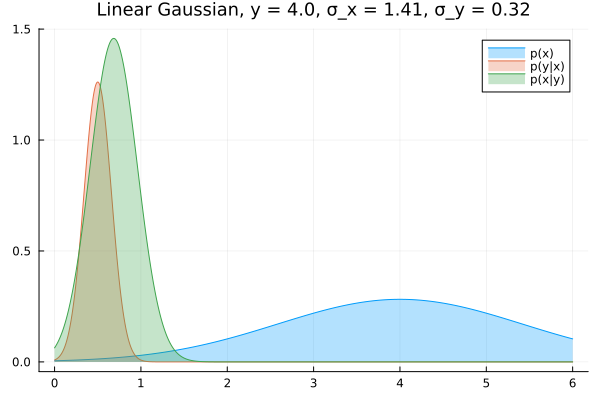

In [13]:
plot()
y_data = [4.0]
plot(title=make_plot_title(y_data[1], stddev_x, stddev_y), titlefontsize=12)
generative_model(y_data, mu_x, stddev_x, γ, stddev_y, rng)